In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import Model
# from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from tensorflow.keras.models import load_model

In [ ]:
RATED_FOOD_PATH = '/content/drive/My Drive/capstone_rec_sys/Tensorflow Rec System/Food and Rating Data/Exported Rated Food 07-06-2021 16-35-04.csv'
RATING_PATH = '/content/drive/My Drive/capstone_rec_sys/Tensorflow Rec System/Food and Rating Data/Exported Rating 07-06-2021 16-35-04.csv'
USER_PATH = '/content/drive/My Drive/capstone_rec_sys/Tensorflow Rec System/Food and Rating Data/Exported User 07-06-2021 16-35-04.csv'

**1. Read Exported CSV From DB**

In [ ]:
food_df = pd.read_csv(RATED_FOOD_PATH)
rating = pd.read_csv(RATING_PATH)
user_df = pd.read_csv(USER_PATH)

In [ ]:
food_df.head()

,food_id,food_code,name,category,type,calories,protein,carbs,fat,fiber,sugar,vitamin_a,vitamin_b6,vitamin_b12,vitamin_c,vitamin_d,vitamin_e
0,8,11432000,"Yogurt, low fat milk, fruit",Yogurt,Food,89.0,4.66,14.46,1.37,0.1,12.01,12.0,0.046,0.49,1.8,1.2,0.04
1,13,11435100,"Yogurt, Greek, with oats",Yogurt,Food,160.0,8.90,22.38,4.29,1.9,12.07,88.0,0.077,0.53,0.1,0.7,0.24
2,15,11446000,"Yogurt parfait, low fat, with fruit",Yogurt,Food,84.0,3.36,15.86,1.01,1.1,11.68,30.0,0.233,0.88,14.3,1.2,0.25
3,16,14710200,"Beer cheese soup, made with milk",Soups,Food,192.0,6.19,6.52,15.43,0.3,0.80,182.0,0.037,0.26,0.3,0.3,0.45
4,23,26109133,"Cod, coated, baked or broiled, no added fat",Fish,Food,137.0,17.32,13.10,1.16,0.6,1.15,9.0,0.121,1.81,0.0,0.6,0.54


In [ ]:
rating.head()

,rating_id,user_id,food_id,food_code,rating
0,3,1,120,27445220,2
1,4,1,176,32105210,2
2,5,1,184,41311030,3
3,6,1,193,42401100,2
4,7,4,365,42403010,4


In [ ]:
user_df.head()

,user_id,name,username,email
0,1,Gugun Andriawan,username0,username0@ayohealthy.id
1,4,Mikey,username4,username4@ayohealthy.id
2,5,BrutusSmith,username5,username5@ayohealthy.id
3,6,Guts,username6,username6@ayohealthy.id
4,9,Imam Septian,username9,username9@ayohealthy.id


In [ ]:
rating.dropna(inplace=True)

In [ ]:
rating.isna().sum()

rating_id    0
user_id      0
food_id      0
food_code    0
rating       0
dtype: int64

**2. Encode User_ID and Rating using LabelEncoder()**

In [ ]:
user_enc = LabelEncoder()
rating['User_ID'] = user_enc.fit_transform(rating['user_id'])

food_enc = LabelEncoder()
rating['Food_ID'] = food_enc.fit_transform(rating['food_code'])
rating.head()

,rating_id,user_id,food_id,food_code,rating,User_ID,Food_ID
0,3,1,120,27445220,2,0,40
1,4,1,176,32105210,2,0,59
2,5,1,184,41311030,3,0,65
3,6,1,193,42401100,2,0,69
4,7,4,365,42403010,4,1,70


In [ ]:
userid_nunique = rating['User_ID'].nunique()
food_unique = rating['Food_ID'].nunique()

print('User_id total unique:', userid_nunique)
print('Food ID total unique:', food_unique)

User_id total unique: 138
Food ID total unique: 140


**3. Build Tensorflow Recommendation Model**

In [ ]:
def RecommenderV2(n_users, n_food, n_dim):
    
    # User Embedding
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Food Rating Embedding
    food = Input(shape=(1,))
    M = Embedding(n_food, n_dim)(food)
    M = Flatten()(M)
    

    merged_vector = concatenate([U, M])
    dense_1 = Dense(128, activation='relu')(merged_vector)
    dense_2 = Dense(64, activation='relu')(dense_1)
    final = Dense(1)(dense_2)
    
    model = Model(inputs=[user, food], outputs=final)
    
    model.compile(optimizer=Adam(0.001), loss='mean_squared_error')
    
    return model

**4. Model Structure**

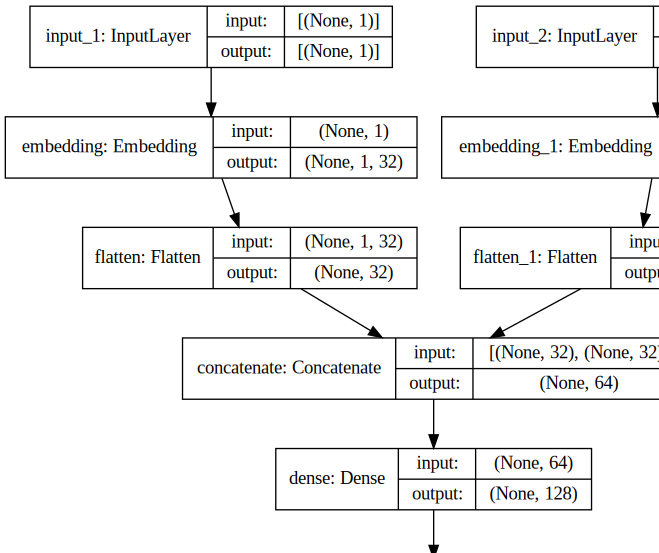

In [ ]:
model = RecommenderV2(userid_nunique, food_unique, 32)

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        4416        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 32)        4480        input_2[0][0]                    
______________________________________________________________________________________________

**5. Split Training and Validation Data**

In [ ]:
from sklearn.model_selection import train_test_split

X = rating.drop(['rating'], axis=1)
y = rating['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify=y,
                                                  random_state=87)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((568, 6), (143, 6), (568,), (143,))

**6. Setting Training Callback**

In [ ]:
checkpoint = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=0, save_best_only=True)
val_loss_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

**7. Train the Data**

In [ ]:
history = model.fit(x=[X_train['User_ID'], X_train['Food_ID']],
                    y=y_train,
                    batch_size=64,
                    epochs=100,
                    verbose=1,
                    validation_data=([X_val['User_ID'], X_val['Food_ID']], y_val),
                    callbacks=[val_loss_cb,checkpoint])

Epoch 1/100
9/9 [==============================] - 1s 23ms/step - loss: 11.6949 - val_loss: 11.1599
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 10.4421 - val_loss: 9.6166
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 8.4297 - val_loss: 7.0381
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 5.3110 - val_loss: 3.4791
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 2.4485 - val_loss: 1.7073
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 2.0257 - val_loss: 1.6559
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - loss: 1.5692 - val_loss: 1.6723
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - loss: 1.3934 - val_loss: 1.6611
Epoch 9/100
9/9 [==============================] - 0s 4ms/step - loss: 1.2552 - val_loss: 1.6831


**8. Plot Model Training and Validation Result**

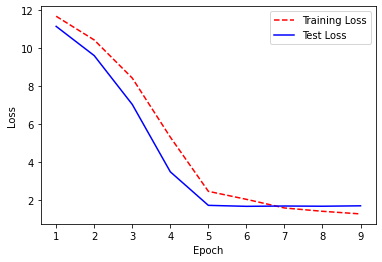

In [ ]:
import matplotlib.pyplot as plt
training_loss2 = history.history['loss']
test_loss2 = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss2) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss2, 'r--')
plt.plot(epoch_count, test_loss2, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

**9. Recommendation DF Function**

In [ ]:
def make_pred(user_id, food_id, model):
    return model.predict([np.array([user_id]), np.array([food_id])])[0][0]

In [ ]:
def get_topN_rec(user_id, model):
    user_ratings = rating[rating['user_id'] == user_id]
    converted_id = rating[rating['user_id'] == user_id].head(1).User_ID.tolist()

    #remove food that user already rated
    recommendation = rating[~rating['Food_ID'].isin(user_ratings['Food_ID'])][['Food_ID','food_code']].drop_duplicates()
    #predict user rating for every user non rated food
    recommendation['rating_predict'] = recommendation.apply(lambda x: make_pred(converted_id[0], x['Food_ID'], model), axis=1)
    
    #create DF user non rated food sorted by rating prediction descending
    final_rec = recommendation.sort_values(by='rating_predict', ascending=False).merge(food_df[['food_code', 'name','type','category']],on='food_code')
    return final_rec.sort_values('rating_predict', ascending=False)[['name','food_code', 'rating_predict','type','category']]

**10. Try Predict Every User Non Rated Food for One User**

In [ ]:
model_title = 'model1.h5'
model = load_model(model_title)

USER_ID = 128
print('USER ID: {} RATED FOOD'.format(USER_ID))
# food_df.loc[food_df['Food_ID'].isin(rating.loc[rating['User_ID']==2]['Food_ID'].to_list())]
rating.loc[rating['user_id']==USER_ID].merge(food_df[['food_code', 'name','category','type']],on='food_code').sort_values(by='rating',ascending=False)

USER ID: 128 RATED FOOD


,rating_id,user_id,food_id,food_code,rating,User_ID,Food_ID,name,category,type
2,609,128,264,71801100,5,113,102,Potato and cheese soup,Soups,Food
5,612,128,380,64104010,5,113,92,"Apple juice, 100%",Fruit drinks,Beverage
0,607,128,282,75403200,4,113,117,"Green beans, cooked, Szechuan-style",Stir-fry and soy-based sauce mixtures,Food
4,611,128,385,64124020,4,113,95,"Pineapple juice, 100%",Fruit drinks,Beverage
1,608,128,189,41812400,3,113,67,Vegetarian pot pie,Bean,Food
3,610,128,202,58151200,2,113,76,"Sushi roll, salmon","Egg rolls, dumplings, sushi",Food
6,613,128,89,27150010,2,113,27,"Fish with cream or white sauce, not tuna or lo...",Seafood mixed dishes,Food
7,614,128,330,11370000,2,113,8,Coconut milk,Milk substitutes,Beverage


In [ ]:
print('RECOMENDATION FOR USER ID : ',USER_ID)
rec_result = get_topN_rec(USER_ID, model)
rec_result

RECOMENDATION FOR USER ID :  128


,name,food_code,rating_predict,type,category
0,Fish chowder,28350050,4.112868,Food,Soups
1,Potato chowder,71803010,4.082446,Food,Soups
2,Stewed potatoes with tomatoes,71704000,4.028926,Food,Potatoes
3,"Chocolate milk, ready to drink, low fat",11511400,4.000147,Beverage,Milk
4,Hunan beef,27415140,3.992905,Food,Stir-fry and soy-based sauce mixtures
...,...,...,...,...,...
127,"Squash, summer, casserole, with rice and tomat...",75418030,2.414117,Food,Vegetable dishes
128,"Codfish salad, Puerto Rican style, Serenata",27451070,2.379884,Food,Seafood mixed dishes
129,Shrimp teriyaki,27150410,2.325166,Food,Stir-fry and soy-based sauce mixtures
130,"Chili with beans, without meat",41221020,2.275250,Food,Bean


**11. Creating Recommendation For All User**

In [ ]:
# create zeros DF that index representing user_id and columns represending food_code
zeros_df = pd.DataFrame(0,index=sorted(rating['user_id'].unique()),columns=food_df['food_code'].tolist())
zeros_df

,11432000,11435100,11446000,14710200,26109133,26109143,26127123,26137123,26153122,26205160,26303160,26315190,26319121,27150010,27150410,27151070,27213010,27243100,27250020,27250030,27250160,27350070,27350410,27363100,27415140,27416400,27445220,27450010,27450020,27450030,27450070,27450080,27450100,27451070,27550420,27550720,27550800,28310110,28311010,28340110,...,11350030,11370000,11511300,11511400,11513370,11513854,11519205,42403010,42404010,61210010,61210250,64100220,64101010,64104010,64104030,64104600,64124020,64132500,64133100,64134100,64201010,73105000,73105010,75132000,75200700,78101118,92510955,92550040,92550360,92550370,92550400,92582100,92611100,92613010,92613510,94220215,95106000,95110020,95312400,95312410
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#create dictionary for every data to labelencoder data
user_dict = {}
food_dict = {}
for index, row in rating.iterrows():
  if(row['user_id'] not in user_dict):
    user_dict[row['user_id']] = row['User_ID']

  if(row['food_code'] not in food_dict):
    food_dict[row['food_code']] = row['Food_ID']

In [ ]:
total_user = len(zeros_df)
step_loop = 0
for index, row in zeros_df.iterrows():
  arr_rated = rating.loc[rating['user_id']==index,'food_code'].tolist()
  for rate in arr_rated:
    zeros_df.loc[index,rate]=rating.loc[(rating['user_id']==index)&(rating['food_code']==rate),'rating'].tolist()[0]

  not_rated = food_df.loc[(~food_df['food_code'].isin(arr_rated)),'food_code'].tolist()
  for rate in not_rated:
    try:

      zeros_df.loc[index,rate]=model.predict([np.array([user_dict[index]]), np.array([food_dict[rate]])])[0][0]
    except:
      zeros_df.loc[index,rate]=0

  step_loop+=1
  print('Filing Row {} / {}'.format(step_loop,total_user))
    

In [ ]:
zeros_df

,11432000,11435100,11446000,14710200,26109133,26109143,26127123,26137123,26153122,26205160,26303160,26315190,26319121,27150010,27150410,27151070,27213010,27243100,27250020,27250030,27250160,27350070,27350410,27363100,27415140,27416400,27445220,27450010,27450020,27450030,27450070,27450080,27450100,27451070,27550420,27550720,27550800,28310110,28311010,28340110,...,11350030,11370000,11511300,11511400,11513370,11513854,11519205,42403010,42404010,61210010,61210250,64100220,64101010,64104010,64104030,64104600,64124020,64132500,64133100,64134100,64201010,73105000,73105010,75132000,75200700,78101118,92510955,92550040,92550360,92550370,92550400,92582100,92611100,92613010,92613510,94220215,95106000,95110020,95312400,95312410
1,2.715820,2.584339,2.935633,3.246140,2.154161,2.810654,2.411565,2.670744,2.635689,2.949790,2.502265,2.183498,2.486450,2.485850,1.615810,2.560643,3.154191,2.854172,2.188422,2.369019,2.520053,1.920984,2.281866,2.026231,3.250957,2.803860,2.000000,2.739386,2.804431,2.645062,1.810116,2.510611,2.344122,1.648735,3.241479,3.240627,2.381999,2.436806,2.922273,2.276970,...,2.822671,2.520645,2.643857,3.256096,2.524651,2.751784,3.153880,2.597306,1.752136,2.817327,2.362489,2.749449,2.874542,3.084678,2.601137,2.444588,2.926150,2.374323,1.849989,2.740814,2.407524,2.371598,2.554106,3.039452,2.148190,3.209346,2.499435,2.764139,1.992830,2.257332,3.063059,2.774009,1.554738,2.077533,2.375273,2.704703,2.904016,2.807736,2.835419,2.633698
4,3.605555,3.485739,3.830560,4.149505,3.031410,3.688031,3.316354,3.541719,3.529478,3.841171,3.398787,3.061900,3.391481,3.366292,2.498172,3.454510,4.042079,3.761169,3.070063,3.255767,3.414370,2.808873,3.179560,2.918365,4.151522,3.703264,3.696533,3.618567,3.692167,3.558390,2.697821,3.399384,3.194089,2.546724,4.149791,4.126922,3.277111,3.339856,3.830628,5.000000,...,3.703766,3.420002,3.548026,4.155095,3.413108,3.638943,4.044301,4.000000,2.644302,3.717206,3.255881,3.649442,3.776741,3.987784,3.449884,3.354139,3.824313,3.281118,2.748625,3.647810,3.307374,3.268038,4.000000,3.930263,3.059275,4.108935,3.397533,3.684838,2.893184,3.168897,3.965458,3.676104,2.428200,2.959107,3.273268,3.601018,3.805614,3.704463,3.716526,3.529017
5,3.344728,3.220512,3.567477,3.882848,2.766781,3.430099,3.038793,3.291643,3.264083,3.574603,3.123017,2.786120,3.111427,3.096964,2.222374,3.193421,3.787469,3.489694,2.802197,2.992171,3.000000,2.530721,2.916489,2.655033,3.889469,3.441200,4.000000,3.356442,3.433087,3.280024,1.000000,3.132336,2.936429,2.274516,3.883042,3.865057,3.024132,3.071631,3.558096,2.901766,...,2.000000,3.151712,3.288562,5.000000,3.142924,3.374554,3.782312,3.229810,2.374025,3.456718,2.986714,3.383554,3.499622,3.718714,3.199879,3.075801,3.561125,3.006971,2.477360,3.374081,3.035988,2.996896,3.188139,3.671947,2.772306,3.855019,3.141182,3.406321,2.621736,2.897351,3.690682,3.408915,2.151538,2.691816,3.004721,3.338602,3.541200,3.445706,3.461222,3.268727
6,2.734785,2.607886,2.968036,3.274359,2.174488,2.821789,2.430687,2.672391,2.658700,2.961060,2.516261,2.181764,2.497506,2.483852,1.634129,2.577545,3.175803,5.000000,2.209574,3.000000,2.546943,1.933409,2.306102,2.046555,3.261383,2.824595,2.838434,2.745267,3.000000,2.669952,1.846679,2.535767,2.342419,1.700288,3.253389,3.252520,2.401233,2.462152,2.933154,2.287641,...,2.835904,2.546096,2.668717,3.290226,2.540001,2.755793,3.180112,2.614745,1.760134,2.842936,2.366091,2.784212,1.000000,3.108564,2.591015,2.463407,2.936460,2.385407,1.865643,2.760382,2.433084,2.387661,2.577322,3.054924,2.159947,4.000000,2.535893,2.779603,2.016443,2.295386,3.073164,2.798308,1.560927,2.100440,2.406431,2.721404,2.923597,2.837275,2.849480,2.665905
9,4.036640,3.917929,4.264564,4.572200,3.461922,4.108859,3.750125,3.986711,3.962165,4.261996,3.824658,3.498590,3.814742,3.792913,2.931091,3.888763,4.474439,4.177815,3.500383,3.696208,3.836113,3.222130,3.614007,3.344169,4.581913,4.134314,4.135005,4.054600,4.124721,3.984601,3.117346,3.827260,3.635885,2.985932,4.578107,5.000000,3.713089,3.768877,3.000000,3.591468,...,4.132

In [ ]:
food_name_dict = {}
for index, row in food_df.iterrows():
    if(row['food_code'] not in food_name_dict):
        food_name_dict[row['food_code']] = row['name']

**12. Give Recommendation to One User**

In [ ]:
USER_ID = 129
food_code_arr = []
name_arr = []
prediction_arr = []
user_rated_food_code = rating.loc[rating['user_id']==USER_ID,'food_code'].tolist()
for key, value in zeros_df.loc[int(USER_ID)].items():
  if(int(key) not in user_rated_food_code):
    food_code_arr.append(int(key))
    name_arr.append(food_name_dict[int(key)])
    prediction_arr.append(value)

             

In [ ]:
print('Recommendation for user id : {}'.format(USER_ID))
rating.loc[rating['user_id']==USER_ID].merge(food_df[['food_code', 'name','category','type']],on='food_code').sort_values(by='rating',ascending=False)

Recommendation for user id : 129


,rating_id,user_id,food_id,food_code,rating,User_ID,Food_ID,name,category,type
0,615,129,202,58151200,5,114,76,"Sushi roll, salmon","Egg rolls, dumplings, sushi",Food
1,616,129,204,58151220,5,114,78,Sushi roll tuna,"Egg rolls, dumplings, sushi",Food
6,621,129,370,61210010,5,114,88,"Orange juice, 100%, freshly squeezed",Fruit drinks,Beverage
2,617,129,203,58151210,4,114,77,"Sushi roll, shrimp","Egg rolls, dumplings, sushi",Food
5,620,129,372,61210250,4,114,89,"Orange juice, 100%, with calcium added, canned...",Fruit drinks,Beverage
3,618,129,170,32103030,2,114,57,"Egg salad, made with creamy dressing",Eggs and omelets,Food
4,619,129,183,41311020,2,114,64,"Sambar, vegetable stew",Vegetable dishes,Food


In [ ]:
recommendation_columns = {'food_code': food_code_arr,
                                  'name': name_arr,
                                  'predicted_rating': prediction_arr,
                                  }

rec_for_user = pd.DataFrame(data=recommendation_columns)   

In [ ]:
rec_for_user

,food_code,name,predicted_rating
0,11432000,"Yogurt, low fat milk, fruit",3.892745
1,11435100,"Yogurt, Greek, with oats",3.770686
2,11446000,"Yogurt parfait, low fat, with fruit",4.124728
3,14710200,"Beer cheese soup, made with milk",4.437055
4,26109133,"Cod, coated, baked or broiled, no added fat",3.333552
...,...,...,...
128,94220215,"Water, bottled, flavored, sugar free (Glaceau ...",3.887899
129,95106000,"Nutritional drink or shake, ready-to-drink (Mu...",4.084904
130,95110020,"Nutritional drink or shake, high protein, read...",4.002086
131,95312400,"Energy drink, low calorie (Monster)",4.012714


In [ ]:
# SORTED RATING FOR ONE USER
rec_for_user.sort_values(
            by='predicted_rating', ascending=False)

,food_code,name,predicted_rating
69,71801100,Potato and cheese soup,4.785830
41,28350050,Fish chowder,4.562352
70,71803010,Potato chowder,4.545581
68,71704000,Stewed potatoes with tomatoes,4.479091
98,11511400,"Chocolate milk, ready to drink, low fat",4.455794
...,...,...,...
82,75418030,"Squash, summer, casserole, with rice and tomat...",2.876521
33,27451070,"Codfish salad, Puerto Rican style, Serenata",2.839613
14,27150410,Shrimp teriyaki,2.781519
48,41221020,"Chili with beans, without meat",2.731986


In [ ]:
zeros_df.to_csv('TF Recommendation DF.csv', index=False)

**13. Save Predicted DF to CSV**

In [ ]:
zeros_df.to_csv('TF Recommendation Index.csv', index=True)